In [1]:
import MySQLdb, pickle
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter

In [2]:
# Read car_info from MySQL at Amazon Web Service Cloud 
pw = pickle.load(open('./Flask/models/pw.plk','rb'))

db = MySQLdb.connect(
    "13.125.209.138",
    "root",
    pw,
    "used_car",
    charset='utf8',
)

# SQL Query
SQL_QUERY = """
    SELECT *
    FROM used_car;
"""

# Bring car information from MySQL into dataframe
train = pd.read_sql(SQL_QUERY, db)
train.head()

,index,year,title,brand,model,miles,photos,video,exterior_color,interior_color,transmission,drivetrain,star,review_no,vendor,price
0,0,2016,chevrolet corvette z06,chevrolet,corvette,29277,31,1,arctic,adrenaline red,7-speed,rwd,4,153,porsche atlanta perimeter,58999
1,1,2005,bentley continental gt base,bentley,continental,40946,32,1,silver,gray,6-speed,4wd,4,945,almgwinnett,38990
2,2,2018,lamborghini huracan performante,lamborghini,huracan,1130,32,1,grigio,nero ade,7-speed,4wd,5,8,motorcars of georgia,319500
3,3,2013,tesla model s base,tesla,model,83003,32,1,black,black,1-speed,rwd,4,714,atlantaautos,34999
4,4,2009,audi r8 4.2l,audi,r8,32927,24,1,ibis,gray,6-speed,4wd,5,9,hendersonville auto brokers,66885


In [3]:
# Saving data to the database
pickle.dump(train, open("./Flask/models/database.plk","wb"))

In [ ]:
# Group by brand and model
brand_group = list(set(database["brand"]))
model_group = list(set(database["model"]))

In [5]:
# Top 30 car brands
brand_list = []
for brand in Counter(train.brand).most_common(30):
    brand_list.append(brand[0])

In [6]:
# Check the index of data not included in the top 30 car brands
idx_list = []
idx = 0
for i in train["brand"]:
    if i not in brand_list:
        idx_list.append(idx)
    idx += 1

In [7]:
# Only the top 30 car brands are filtered
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)
train = train.drop("index", axis=1)

### Feature engineering

In [8]:
# Select models and brands as category variables
categorical_features = ['brand', 'model']

In [9]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,brand_acura,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_cadillac,brand_chevrolet,brand_dodge,brand_ferrari,...,model_xk8,model_xkr,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4,model_zdx
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Select year, miles, price by numeric variable
# Select by numeric variable
numerical_features = ['year', 'miles','price']

In [13]:
# Normalized numeric Variables
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,year,miles,price
0,7.609367,10.284592,10.985293
1,7.603898,10.620034,10.571086
2,7.610358,7.030857,12.674516
3,7.607878,11.326644,10.463103
4,7.605890,10.402079,11.110745


In [14]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["price"]
X_train = X_train_0.drop("price", axis=1)

### Model : XGBoost Model
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model.

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) x to predict a target variable y. Before we dive into trees, let us start by reviewing the basic elements in supervised learning.

In [16]:
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [17]:
# Create XGBoost Regressor model
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [18]:
# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

CPU times: user 221 ms, sys: 68.1 ms, total: 289 ms
Wall time: 2min 36s
Score = 0.88039


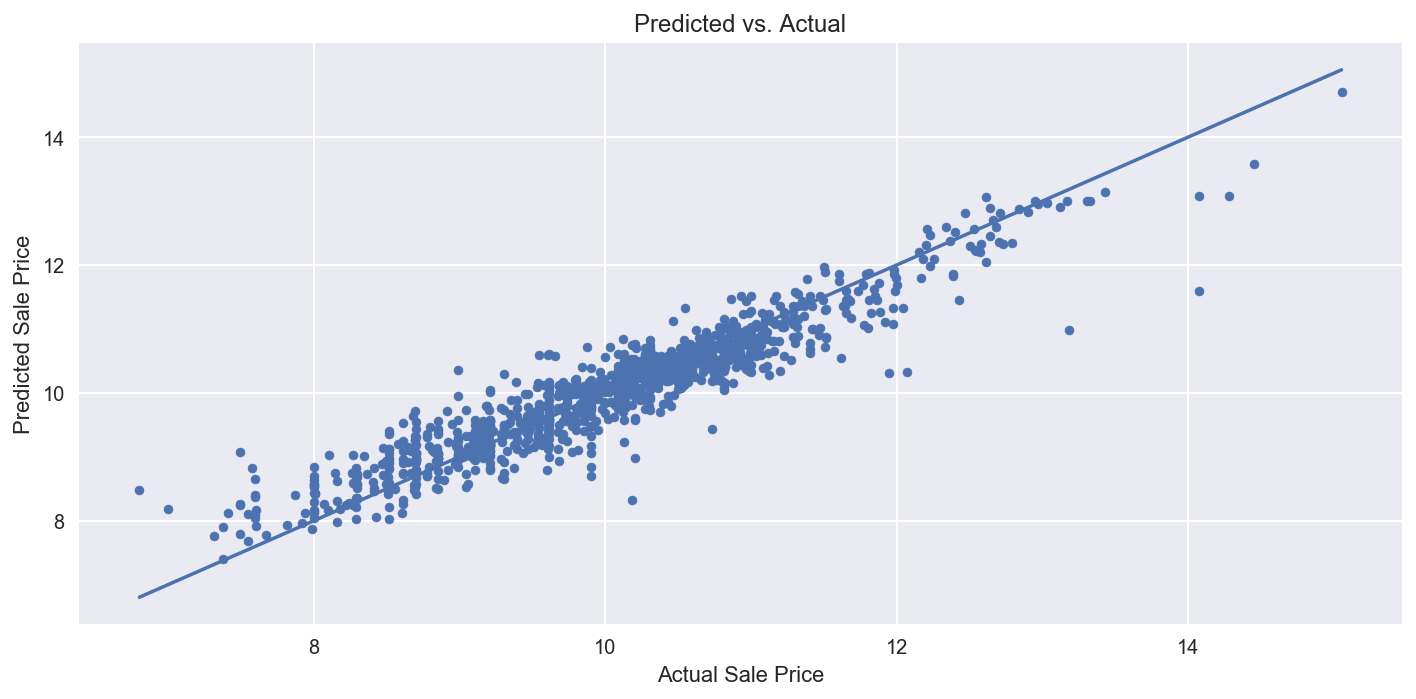

In [19]:
# Train model
ml = ml.fit(X_train1, y_train1)

# Predict test data set
y_pred = ml.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [20]:
# Save the model to the pickle file
pickle.dump(ml, open("./Flask/models/model.plk","wb"))

In [21]:
# Set up a dataset using "brand", "model", "year", "miles", "price"
actual_car_info = train[["brand", "model","year","miles","price"]]

# Save the dataset to the pickle file
pickle.dump(actual_car_info, open("./Flask/models/actual_car_info.plk","wb"))

### Enter Used Car information

In [22]:
# Enter the information of the vehicle you want to know about the estimated price of used car
brand = str(input("brand: "))
model = str(input("model: "))
year = int(input("year: "))
miles = int(input("miles: "))

brand: ford
model: f-150
year: 2011
miles: 30000


In [23]:
# Save the variable column used to train the model as a data frame
target = pd.DataFrame(columns = [X_train1.columns])

In [24]:
# Save the variable column to the pickle file
pickle.dump(X_train1.columns, open("./Flask/models/column.plk","wb"))

In [25]:
# Check the index location of the selected used car brand in the variable column data frame
brand_index = 0
for col in X_train.columns:
    if col == 'brand'+"_"+brand:
        break;
    brand_index += 1
brand_index

12

In [26]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train.columns:
    if col == 'model'+"_"+model:
        break;
    model_index += 1
model_index

190

In [27]:
# Array of zeros
target_list = np.zeros_like(X_train.loc[0])

In [28]:
# Save the target_list to pickle file
pickle.dump(target_list, open("./Flask/models/target_list.plk","wb"))

In [29]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = miles

In [30]:
# Insert data into target data frame 
for i in range(1):
    target.loc[i] = target_list

In [31]:
target

,year,miles,brand_acura,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_cadillac,brand_chevrolet,...,model_xk8,model_xkr,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4,model_zdx
0,2011.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Nomalizing numerical features
numerical_features = ['year', 'miles']
target[numerical_features] = np.log1p(target[numerical_features])

In [33]:
target

,year,miles,brand_acura,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_cadillac,brand_chevrolet,...,model_xk8,model_xkr,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4,model_zdx
0,7.606885,10.308986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict Used_Car Values

In [34]:
# Predicted logged price
price_log = ml.predict(target)

In [35]:
price_log

array([ 10.08207607], dtype=float32)

In [36]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print("Price:", int(price))

Price: 23910


### Compare same model with different years

In [37]:
# Find the average of the same model for each year
same_model = actual_car_info[actual_car_info["model"]==model] 
year_price = same_model[["year", "price"]]
year_price_list = year_price.groupby("year").agg({'price':np.mean}).astype('int')
year_price_list = year_price_list.reset_index()
year_price_list

,year,price
0,1995,2475
1,1996,1795
2,2001,2597
3,2002,8500
4,2003,7489
5,2004,6745
6,2005,7910
7,2006,5196
8,2007,12492
9,2008,12612


In [38]:
# Convert year from number type to character type
year_price_list["year"] = year_price_list["year"].apply(lambda x: str(x) )

In [39]:
# Convert price from number type to character type
year_price_list["price"] = year_price_list["price"].apply(lambda x: str(x) )

In [40]:
list(year_price_list["price"])

['2475',
 '1795',
 '2597',
 '8500',
 '7489',
 '6745',
 '7910',
 '5196',
 '12492',
 '12612',
 '19195',
 '15884',
 '18330',
 '15680',
 '70430',
 '21073',
 '28182',
 '30292',
 '44804',
 '69313']